In [2]:
%matplotlib inline

import numpy
import pandas
import matplotlib.pyplot as plt

import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn import metrics

import librosa
import librosa.display

In [99]:
import tarfile
import re
import io

def load_dataset(featurespath, labelpath, datadir='data/'):    
    features = pandas.read_csv(datadir+featurespath)
    #regex = re.compile(r'wav\/(.*).wav')
    #itemid = features.filename.astype('str').str.replace(pat=regex, repl=lambda m: m.group(1), regex=True)
    itemid = features.filename.str.replace('.wav', '', regex=False).str.replace('wav/', '')
    features.index = itemid

    data = features.copy()
    
    labels = pandas.read_csv(datadir+labelpath, index_col='itemid')
    labels.index = labels.index.astype('str')
    data['hasbird'] = labels.hasbird.astype('bool')

    return data


In [100]:
train_ff1010 = load_dataset('ff1010bird_wav.melmax.csv', 'ff1010bird.labels.csv')
train_warblr = load_dataset('warblrb10k_public_wav.melmax.csv', 'warblrb10k.labels.csv')
#predict_poland = load_dataset('PolandNFC_test_wav.melmax.csv')
#predict_warblr = load_dataset('wabrlrb10k_test_wav.melmax.csv')
#predict_chern = load_dataset('chern_wav.melmax.csv')

dataset = pandas.concat([train_ff1010, train_warblr])
dataset.shape

(15690, 66)

In [104]:
def plot_precision_recall(Y_test, Y_score):
    average_precision = metrics.average_precision_score(Y_test, Y_score)
    precision, recall, _ = metrics.precision_recall_curve(Y_test, Y_score)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [95]:
dataset = dataset.sample(5000)

In [101]:
label_columns = ['hasbird']
ignore_columns = ['filename']
feature_columns = list(set(dataset.columns) - set(label_columns) - set(ignore_columns))
X = dataset[feature_columns]
Y = dataset[label_columns[0]]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=1)
print('dataset', X.shape, Y.shape, numpy.mean(Y))

rf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, random_state=1),
)

scores = model_selection.cross_val_score(rf, X_train, Y_train, scoring='roc_auc', cv=10)
print('CV: {:.4f} {:.4f}'.format(numpy.mean(scores), numpy.std(scores)))

rf.fit(X_train, Y_train)
roc_auc = metrics.roc_auc_score(Y_train, rf.predict_proba(X_train)[:,1])
print('Train', roc_auc)

# test
roc_auc = metrics.roc_auc_score(Y_test, rf.predict_proba(X_test)[:,1])
Y_pred = rf.predict(X_test)
recall = metrics.recall_score(Y_test, Y_pred)
print('Test', roc_auc)

print('recall', recall)

metrics.confusion_matrix(Y_test, Y_pred)

dataset (15690, 64) (15690,) 0.5086042065009561
CV: 0.8567 0.0089
Train 1.0
Test 0.8685669796780907
recall 0.7857744107744108


array([[1798,  533],
       [ 509, 1867]])

In [102]:
cf = metrics.confusion_matrix(Y_test, Y_pred)
numpy.round(cf / cf.sum(axis=0), 4)*100

array([[77.94, 22.21],
       [22.06, 77.79]])

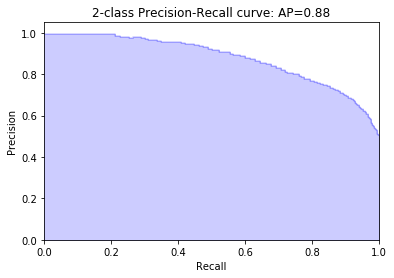

In [105]:
plot_precision_recall(Y_test, rf.predict_proba(X_test)[:,1])

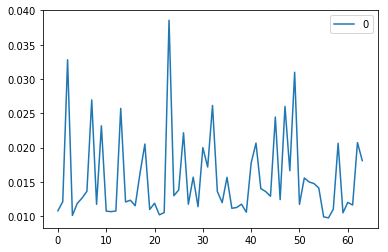

In [106]:
pandas.DataFrame(rf.steps[1][1].feature_importances_).plot()